In [33]:
import pandas as pd

data = pd.read_csv('data/dataframes/dataframe_2007to2022.csv', index_col=0)
label = pd.read_csv('data/dataframes/label_2007to2022.csv', index_col=0)

In [34]:
data

,date,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2007-01-01,0,212,538,1743,0,1020,948,1558,625,581,4363
2007-01-01,0,631,298,4627,1,181,1025,1043,733,440,6421
2007-01-01,0,671,427,3949,0,955,1212,0,584,901,1884
2007-01-01,0,703,585,2159,0,238,1803,0,565,993,1063
2007-01-01,0,536,524,2711,0,862,1757,983,1066,880,1131
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,834,346,668,1043,1,70,767,0,642,682,3100
2022-12-26,834,405,655,2675,0,46,249,1852,821,758,1270
2022-12-26,834,432,594,1716,1,662,1373,75,655,558,1652
2022-12-26,834,377,393,3764,1,595,2132,80,621,549,897


In [67]:
label

,0
2007-01-01,1
2007-01-01,2
2007-01-01,3
2007-01-01,4
2007-01-01,5
...,...
2022-12-26,96
2022-12-26,97
2022-12-26,98
2022-12-26,99


In [84]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
data_std = std.fit_transform(data)
data_std = pd.DataFrame(data, columns=data.columns, index=data.index)

In [36]:
import numpy as np
from datetime import datetime

def create_sequences(s_year, dataframe, label):
    Xs, ys = [], []
    curday = datetime(s_year, 1, 1)
    dayformat = curday.strftime('%Y-%m-%d')
    for idx in dataframe.index:
        X = dataframe.loc[dayformat].values
        y = label.loc[dayformat].values
        
        s = np.arange(X.shape[0])
        np.random.shuffle(s)
        X = X[s]
        y = y[s]
        
        Xs.append(X)
        ys.append(y)
        if idx != dayformat:
            dayformat = idx
        
    return np.array(Xs, dtype=object), np.array(ys, dtype=object)

In [47]:
X, y = create_sequences(2007, data_std, label)
X.shape, y.shape

((83500, 100, 11), (83500, 100, 1))

In [48]:
def sequenceFlatter(X):
    temp = []
    for x in X:
        for i in x:
            temp.append(i)
    temp = np.array(temp)
    return temp

In [49]:
X = sequenceFlatter(X)
y = sequenceFlatter(y)



In [50]:
X.shape

(8350000, 11)

In [59]:
y = y.flatten()
y.shape

(8350000,)

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


[3.85935927e+06 1.49562678e+06 3.61279135e+05 3.17696934e+05
 1.15440601e+05 5.99735034e+04 4.54342994e+04 3.40262597e+04
 1.73185980e+04 1.10336819e+04 2.22095220e-01]
[6.10929814e-01 2.36755099e-01 5.71898544e-02 5.02908682e-02
 1.82740449e-02 9.49370055e-03 7.19217003e-03 5.38629732e-03
 2.74150373e-03 1.74661252e-03 3.51572843e-08]


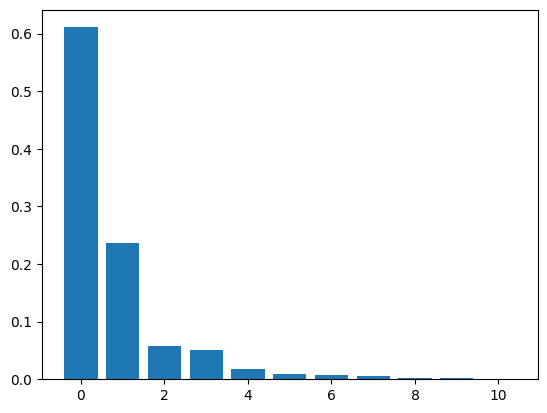

In [61]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

x_length = len(X_train[0])
x = np.arange(x_length)

import matplotlib.pyplot as plt 

plt.bar(x, pca.explained_variance_ratio_)
plt.show()

In [62]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [65]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

def modelingAndVisualizing(X_train, X_test, title):
    knn = KNeighborsRegressor(n_neighbors=10)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)

    print(title)
    print('학습 정확도 : ', round(train_score, 3))
    print('검증 정확도 : ', round(test_score, 3))
    print("평균 정확도", np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    
    plt.plot(range(100), y_test[:100], label='True')
    plt.plot(range(100), y_pred[:100], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()
    return knn

Standardized
학습 정확도 :  1.0
검증 정확도 :  -1.034
평균 정확도 -1.0620965235837097


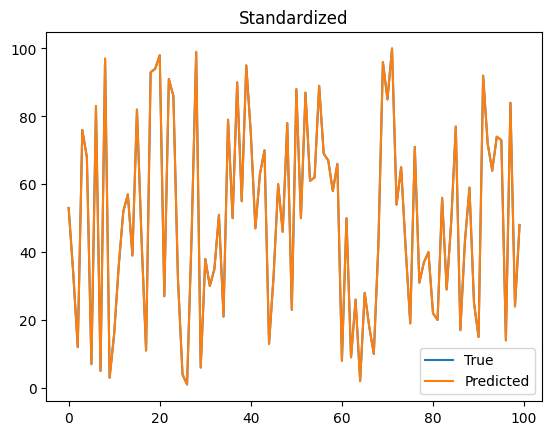

Standardized_PCA
학습 정확도 :  1.0
검증 정확도 :  -1.034
평균 정확도 -1.0622006108910205


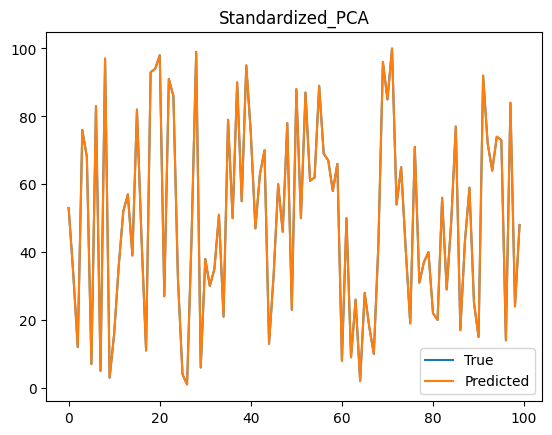

In [66]:
modelingList = [
    (X_train, X_test, 'Standardized'),
    (X_train_pca, X_test_pca, 'Standardized_PCA'),
]

import joblib
import os

for model in modelingList:
    knn = modelingAndVisualizing(*model)
    # save model to file
    # if not os.path.exists('models'):
    #     os.makedirs('models')
    #     filePath = 'models/' + model[2] + '.pkl'
    #     joblib.dump(knn, filePath)
    

In [86]:


data2023 = pd.read_csv('data/dataframes/dataframe_2023to2023.csv', index_col=0)
label2023 = pd.read_csv('data/dataframes/label_2023to2023.csv', index_col=0)

In [87]:
data2023['date'] = data2023['date'] + 835
data2023

,date,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2023-01-01,835,12,206,574,1,106,333,0,31,173,414
2023-01-01,835,173,97,666,1,172,524,0,358,463,547
2023-01-01,835,300,74,652,1,91,527,0,21,430,113
2023-01-01,835,283,100,47,1,34,350,199,327,476,42
2023-01-01,835,240,50,49,1,43,514,0,41,466,322
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,887,187,381,100,1,247,223,0,317,404,416
2023-12-31,887,262,361,196,0,319,189,0,318,434,30
2023-12-31,887,92,331,273,1,38,311,22,158,240,393
2023-12-31,887,344,427,253,0,125,347,142,176,475,167


In [90]:
data2023_std = std.transform(data2023)
data2023_std = pd.DataFrame(data2023_std, columns=data2023.columns, index=data2023.index)

In [91]:
X2023, y2023 = create_sequences(2023, data2023_std, label2023)
X2023 = X2023.reshape(X2023.shape[0]*X2023.shape[1], X2023.shape[2])
y2023 = y2023.reshape(y2023.shape[0]*y2023.shape[1], 1)

In [92]:
X2023_pca = pca.transform(X2023)


In [93]:
list2023 = [
    (X2023, 'Standardized'),
    (X2023_pca, 'Standardized_PCA'),
]


In [94]:
def modelingAndVisualizing2023(X_train, y_train, data, label, title):
    knn = KNeighborsRegressor(n_neighbors=10)
    knn.fit(X_train, y_train)
    pred = knn.predict(data)
    
    train_score = knn.score(X_train, y_train)

    print(title)
    print('학습 정확도 : ', round(train_score, 3))
    print("평균 예측 정확도", np.mean(cross_val_score(knn, data, label, cv=5)))
    
    plt.plot(range(100), label[:100], label='True 2023')
    plt.plot(range(100), pred[:100], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()
    return knn

In [95]:
listFor2023 = [
    (X_train, y_train, X2023, y2023, 'Standardized'),
    (X_train_pca, y_train, X2023_pca, y2023, 'Standardized_PCA')

]

Standardized
학습 정확도 :  1.0
평균 예측 정확도 0.2615941587052333


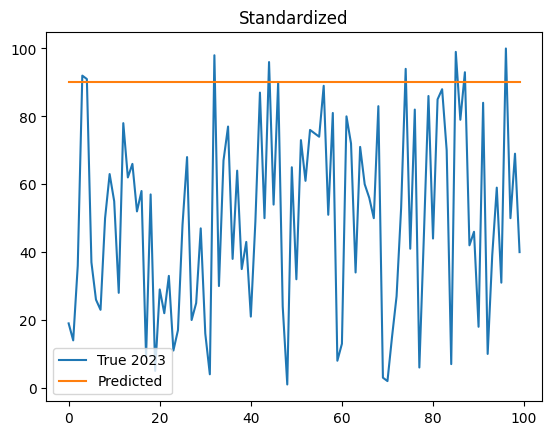

Standardized_PCA
학습 정확도 :  1.0
평균 예측 정확도 0.2597458425980567


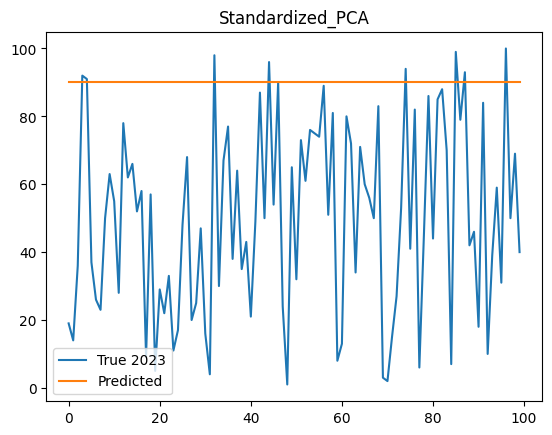

In [96]:
for model in listFor2023:
    modelingAndVisualizing2023(*model)

Standardized_PCA
Best parameters :  {'algorithm': 'brute', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
Best score :  -0.08771831244025645
Best estimator test score :  -0.08637839235782163
Standardized_PCA


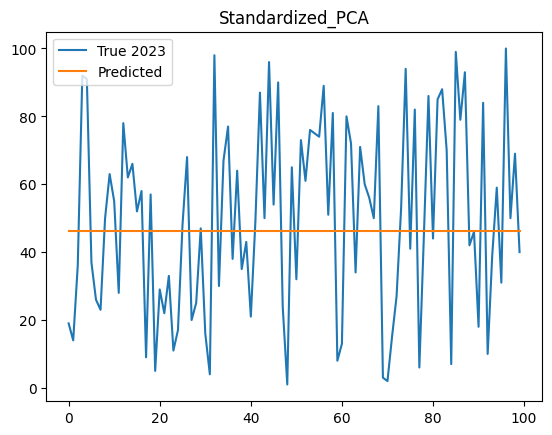

In [97]:
# GridSearchCV로 KNN의 최적 파라미터 찾기
# 최적 모델 선정 후 models/best_KNN.pkl로 저장
# 최적 모델로 2023년 데이터 예측 후 시각화

from sklearn.model_selection import GridSearchCV

def getBestKNN(X_train, X_test, title):
    knn = KNeighborsRegressor()
    param_grid = {
        'n_neighbors': [2,3,4,5,6,7,8,9,10],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski','euclidean','manhattan'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10,20,30,40,50,60,70,80,90,100],
        'p': [1,2]
    }

    grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='r2')
    grid_search.fit(X_train[-20000:], y_train[:20000])
    
    print(title)
    print('Best parameters : ', grid_search.best_params_)
    print('Best score : ', grid_search.best_score_)
    print('Best estimator test score : ', grid_search.best_estimator_.score(X_test, y_test))

    return grid_search.best_estimator_

knnList = [
    (X_train_pca, X_test_pca, 'Standardized_PCA')
]

list2023 = [
    (X2023_pca, 'Standardized_PCA')
    
]

# modelingList의 데이터로 학습한 최적 모델로 list2023의 데이터들로 2023년 데이터 예측
def predict2023(model, data, label, title):
    pred = model.predict(data)
    
    print(title)
    plt.plot(range(100), label[:100], label='True 2023')
    plt.plot(range(100), pred[:100], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()
    
for knn, model in zip(knnList, list2023):
    bestModel = getBestKNN(*knn)
    predict2023(bestModel, model[0], y2023, model[1])

In [29]:
def modelingAndVisualizing2023(X_train, X_test, title, data, label, n_neighbors, metric='minkowski'):
    knn = KNeighborsRegressor(algorithm='ball_tree', leaf_size=60, n_neighbors=n_neighbors, metric=metric)
    knn.fit(X_train, y_train)
    test = knn.predict(X_test)
    pred = knn.predict(data)
    
    train_score = knn.score(X_train, y_train)

    print(title)
    print('학습 정확도 : ', round(train_score, 3))
    print("평균 예측 정확도", np.mean(cross_val_score(knn, data, label, cv=5)))
    
    plt.plot(range(100), y_test[:100], label='True Test')
    plt.plot(range(100), test[:100], label='Predicted')
    plt.title("Test " + title)
    plt.legend()
    plt.show()
    
    plt.plot(range(100), label[:100], label='True 2023')
    plt.plot(range(100), pred[:100], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()
    return knn

In [30]:
for knn, model in zip(knnList, list2023):
    modelingAndVisualizing2023(*knn, model[0], y2023, 10)

Standardized
학습 정확도 :  0.581
평균 예측 정확도 0.22419541528355916


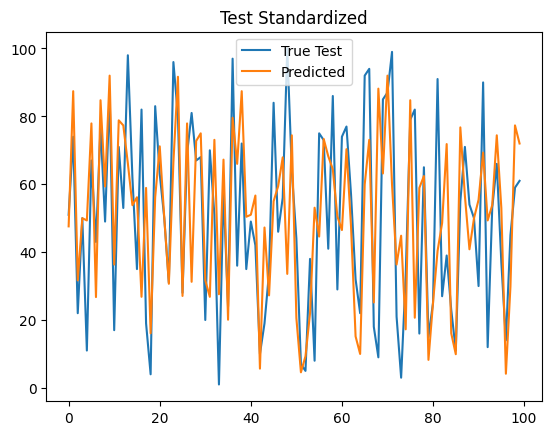

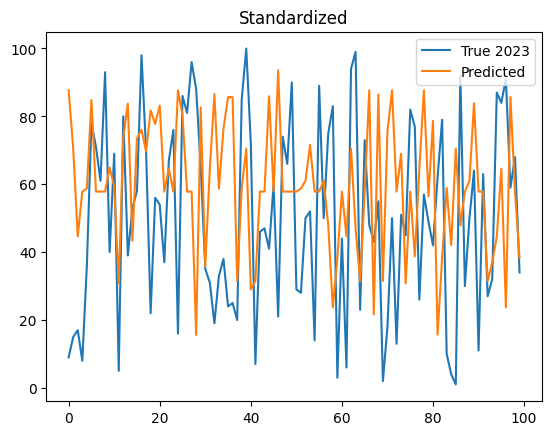

Standardized_LDA
학습 정확도 :  0.58
평균 예측 정확도 0.24077746752775536


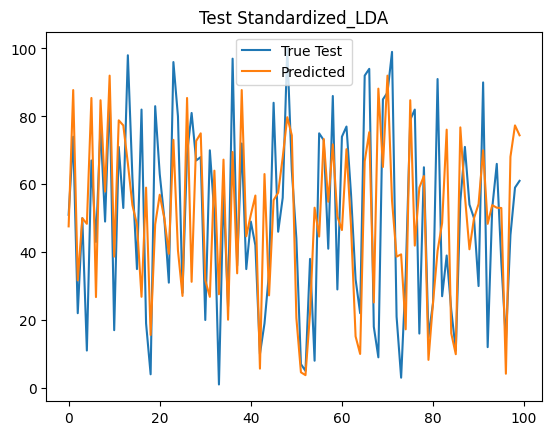

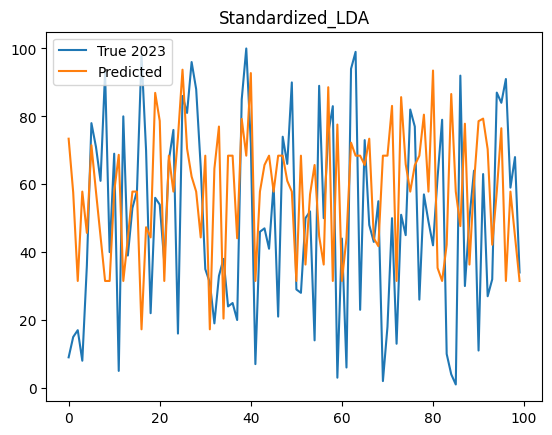

In [33]:
for knn, model in zip(knnList, list2023):
    modelingAndVisualizing2023(*knn, model[0], y2023, 12, 'manhattan')

Standardized
학습 정확도 :  0.881
평균 예측 정확도 0.29292737437456534


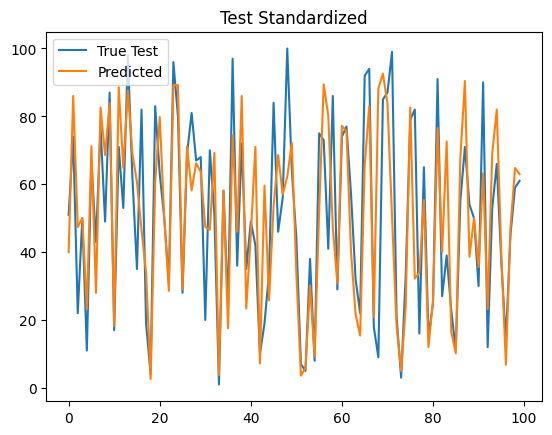

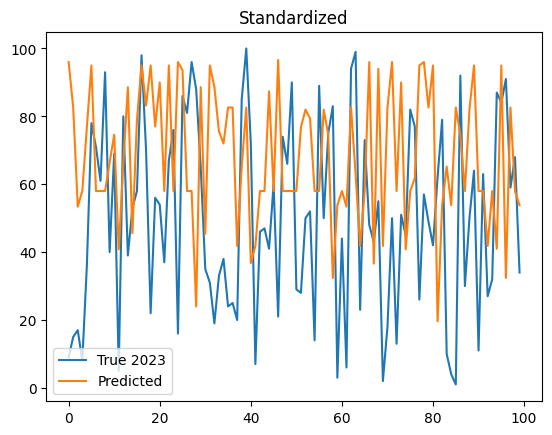

Standardized_LDA
학습 정확도 :  0.881
평균 예측 정확도 0.2922138700750828


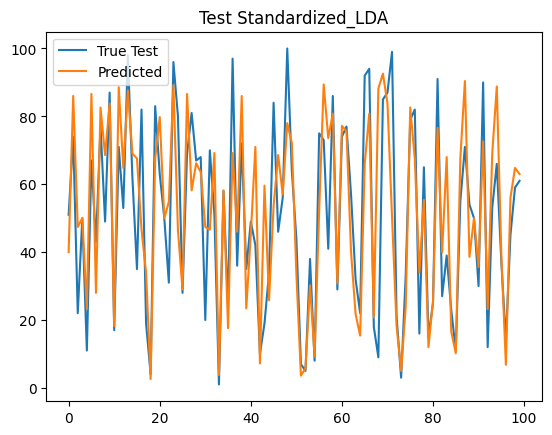

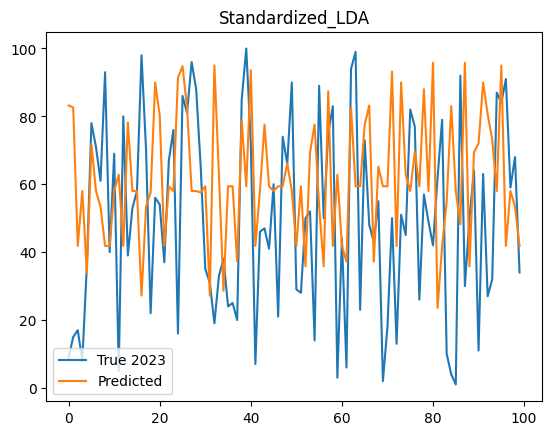

In [35]:
for knn, model in zip(knnList, list2023):
    modelingAndVisualizing2023(*knn, model[0], y2023, 5, 'manhattan')